# Predict sin function using TensorFlow

介绍: 基于sinx的前n个结果,推测下一个结果.最终会绘制出整个预测值,由于预测的时候是按x增长的,所以最后应该绘制出和sinx一样的曲线

Step 1: Import packages

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import sys

print(tf.__version__)

1.10.0


Step 2: Define constans

In [2]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # used in jupyter notebook to prevent error reports

tf.flags.DEFINE_integer("training_examples", 10000, "number of training examples")
tf.flags.DEFINE_integer("testing_examples", 1000, "number of testing examples")
tf.flags.DEFINE_float("sample_gap", 0.01, "sample gap")
tf.flags.DEFINE_integer("max_time", 10, "the max time steps of RNN")
tf.flags.DEFINE_integer("lstm_size", 30, "number of hidden nodes in RNN")
tf.flags.DEFINE_integer("num_layers", 2, "number of layers of RNN")
tf.flags.DEFINE_float("learning_rate", 0.1, "learning rate")
tf.flags.DEFINE_integer("num_classes", 1, "num of classes")
tf.flags.DEFINE_integer("num_epochs", 3000, "num of ")
tf.flags.DEFINE_float("keep_prob", 1, "keep prob")
tf.flags.DEFINE_integer("embedding_size", 1, "embedding size")
tf.flags.DEFINE_integer("batch_size", 64, "batch size")
tf.flags.DEFINE_integer("log_every", 100, "log_every")


FLAGS = tf.flags.FLAGS
FLAGS(sys.argv) # flags

['/home/orris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py']

Step 3: Prepare data.

In [3]:
def generate_data(start_pos, end_pos, total, max_time):
    # given start_pos
    # given end_pos
    # generate xs
    xs = np.linspace(start_pos, end_pos, total + max_time, dtype=np.float32)
    # generate ys
    ys = np.sin(xs)

    X = []
    y = []

    # how many data
    for i in range(total):
        # generate X from ys
        X.append(ys[i:i + max_time,np.newaxis])
        # generate y from ys
        y.append([ys[i + max_time]])

    # return X,y
    return np.array(X), np.array(y)

Step 4: Build models.

In [4]:
class Model(object):
    def __init__(self,max_time, embedding_size, num_classes, learning_rate, lstm_size, num_layers,X,y):
        with tf.name_scope('placeholder'):
            # what's the shape of features??? 3d or 2d???
            # defines features
            #self.features = tf.placeholder(tf.float32,[None,max_time, embedding_size], name='features') 
            self.features = X
            # defines labels
            #self.labels = tf.placeholder(tf.float32,[None,num_classes], name='labels')
            self.labels = y
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            self.learning_rate = learning_rate


        def create_lstm_cell(lstm_size, output_keep_prob):
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(lstm_size,state_is_tuple=True)
            lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=output_keep_prob)
            return lstm_cell

        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell([create_lstm_cell(lstm_size, self.keep_prob) for _ in range(num_layers)])


        # calc output
        outputs,final_state = tf.nn.dynamic_rnn(stacked_lstm,self.features,dtype=tf.float32)
        #output = tf.squeeze(outputs[:,-1,:])
        output = outputs[:,-1,:]

        # calc y_predicted
        #y_predicted = self.nn(final_state[1],num_classes,None,'fully')
        self.y_predicted = tf.contrib.layers.fully_connected(output,1,activation_fn=None)
        
        # defines loss
        self.loss = tf.losses.mean_squared_error(labels=self.labels,predictions=self.y_predicted)
    
        # defines train_op
        self.train = tf.contrib.layers.optimize_loss(self.loss,tf.train.get_global_step(),optimizer="Adagrad",learning_rate=self.learning_rate)
        
        # defines accuracy op
        
        
# train



Step 5: Train models and evaluate the model.

step 100:loss=0.0026398375630378723
step 200:loss=0.002967814914882183
step 300:loss=0.001363416900858283
step 400:loss=0.001549293752759695
step 500:loss=0.0017870449228212237
step 600:loss=0.0012620417401194572
step 700:loss=0.0012233494780957699
step 800:loss=0.0014613026287406683
step 900:loss=0.0011496222577989101
step 1000:loss=0.0014106733724474907
step 1100:loss=0.001060933107510209
step 1200:loss=0.001234200899489224
step 1300:loss=0.000996486283838749
step 1400:loss=0.000963799946475774
step 1500:loss=0.0009060075390152633
step 1600:loss=0.0008366501424461603
step 1700:loss=0.0010240364354103804
step 1800:loss=0.0009074404370039701
step 1900:loss=0.0008641399908810854
step 2000:loss=0.0007752865203656256
step 2100:loss=0.000658421020489186
step 2200:loss=0.0005911633488722146
step 2300:loss=0.0006353642093017697
step 2400:loss=0.0006478320574387908
step 2500:loss=0.0006473112152889371
step 2600:loss=0.0005619628354907036
step 2700:loss=0.00047000590711832047
step 2800:loss=0.

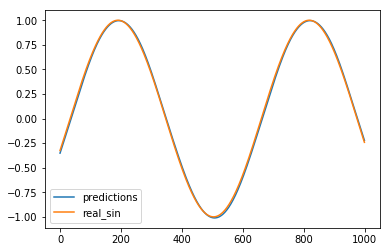

drawing completed


In [5]:
def train(sess, X_train, y_train):
    # given session object
    ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
    ds = ds.repeat().shuffle(1000).batch(FLAGS.batch_size)
    X, y = ds.make_one_shot_iterator().get_next()

    # creates the model
    model = Model(FLAGS.max_time,1,1,FLAGS.learning_rate,FLAGS.lstm_size,FLAGS.num_layers,X,y)

    # initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # for(i;0=>num_epochs)
    for i in range(FLAGS.num_epochs):
        # get X,y (batch_size,xxx)
        _, loss = sess.run([model.train,model.loss],feed_dict={model.keep_prob:FLAGS.keep_prob})
        if (i + 1) % FLAGS.log_every == 0:
            print('step {0}:loss={1}'.format(i + 1,loss))

def test(sess, X_test,y_test):
    # given session object
    # given X_test,y_test
    # generate batches
    ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    

    # create the model
    model = Model(FLAGS.max_time,1,1,FLAGS.learning_rate,FLAGS.lstm_size,FLAGS.num_layers,X,y)
    y_predicted = []
    labels = []
    for i in range(FLAGS.testing_examples):
        p, l = sess.run([model.y_predicted,model.labels],feed_dict={model.keep_prob:1})
        y_predicted.append(p)
        labels.append(l)

    # run accuracy
    y_predicted = np.squeeze(np.array(y_predicted))
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((y_predicted - labels) ** 2).mean(axis=0))
    print('Mean Square Error is : %f'%rmse)

    print('drawing starts')
    plt.figure()
    plt.plot(y_predicted,label='predictions')
    plt.plot(labels,label='real_sin')
    plt.legend()
    plt.show()
    print('drawing completed')

# main
def main():
    # calculate training pos
    training_pos = (FLAGS.training_examples + FLAGS.max_time) * FLAGS.sample_gap
    # calculate testing pos
    testing_pos = training_pos + (FLAGS.testing_examples + FLAGS.max_time) * FLAGS.sample_gap
    # generate training data
    X_train, y_train = generate_data(0, training_pos, FLAGS.training_examples,FLAGS.max_time)
    # generate test data
    X_test, y_test = generate_data(training_pos, testing_pos, FLAGS.testing_examples, FLAGS.max_time)

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        # train
        with tf.variable_scope('model'):
            train(sess,X_train,y_train)
        # test
        with tf.variable_scope('model',reuse=True):
            test(sess,X_test,y_test)



if __name__ == '__main__':
    main()